In [26]:
pip install stable-baselines3

In [27]:
pip install opencv-python

In [1]:
import torch
import torchvision

In [2]:
import cv2

cap = cv2.VideoCapture(0)  # 0 for laptop webcam, or appropriate index for USB/camera module





# Object detection


In [3]:
pip install yolov5

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-8-18 Python-3.11.13 torch-2.6.0+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 80.6MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


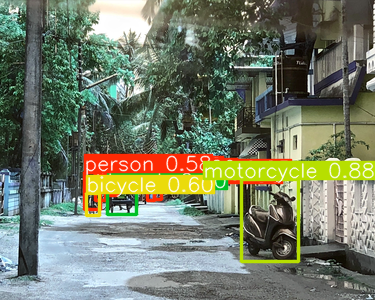

In [4]:
import cv2
import torch
from google.colab.patches import cv2_imshow # Import cv2_imshow for Colab

model=torch.hub.load('ultralytics/yolov5','yolov5s',pretrained=True)

# cap=cv2.VideoCapture(0) # Webcam input is not directly supported in Colab

# For demonstration, let's process a static image instead of a webcam feed
# You can upload an image to your Colab environment and change the path below
image_path = '/content/bus.png' # Example image path

try:
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Could not load image from {image_path}")
    else:
        # YOLO expects RGB images
        results = model(frame[..., ::-1])

        # Draw detected objects on frame
        annotated = results.render()[0]

        # Display the annotated image in the notebook
        cv2_imshow(annotated)

except Exception as e:
    print(f"An error occurred: {e}")

# Release the capture and destroy windows (not needed for static image)
# cap.release()
# cv2.destroyAllWindows()

# Integration with navigation system

In [5]:
# Convert detections to map coordinates
def detections_to_map_coords(detected_objects, drone_pose):
    """Convert pixel coordinates to world coordinates"""
    map_objects = []
    for obj in detected_objects:
        # Transform from camera coordinates to world coordinates
        # Using drone's current pose and camera calibration
        world_x, world_y = pixel_to_world(obj['center'], drone_pose)
        map_objects.append({
            'world_pos': (world_x, world_y),
            'type': obj['label'],
            'confidence': obj['confidence']
        })
    return map_objects


for rl


In [6]:
def create_state_vector(detected_objects, frame_shape):
    """Create state representation for RL agent"""
    # Create grid-based representation
    grid_size = 64
    obstacle_grid = np.zeros((grid_size, grid_size))

    for obj in detected_objects:
        if obj['label'] in ['person', 'car', 'truck']:  # obstacles
            # Map to grid coordinates
            grid_x = int(obj['center'][0] / frame_shape * grid_size)
            grid_y = int(obj['center'] / frame_shape * grid_size)
            obstacle_grid[grid_y, grid_x] = obj['confidence']

    return obstacle_grid.flatten()


In [7]:
{
    'timestamp': 1625123456.789,
    'label': 'person',
    'confidence': 0.85,
    'bbox': (100, 150, 200, 300),
    'center': (150, 225),
    'dimensions': (100, 150),
    'area': 15000,
    'distance': 5.2  # optional
}


{'timestamp': 1625123456.789,
 'label': 'person',
 'confidence': 0.85,
 'bbox': (100, 150, 200, 300),
 'center': (150, 225),
 'dimensions': (100, 150),
 'area': 15000,
 'distance': 5.2}

In [8]:
pip install opencv-python numpy torch torchvision gym stable-baselines3 djitellopy


In [9]:
import cv2
import numpy as np

class SimpleObjectDetector:
    def __init__(self):
        # Use OpenCV's built-in cascade classifiers (lightweight)
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # Simple color-based detection for obstacles
        self.obstacle_colors = {
            'red': ([0, 50, 50], [10, 255, 255]),
            'green': ([40, 50, 50], [80, 255, 255]),
            'blue': ([100, 50, 50], [130, 255, 255])
        }

    def detect_faces(self, frame):
        """Detect faces as obstacles"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)

        obstacles = []
        for (x, y, w, h) in faces:
            obstacles.append({
                'type': 'person',
                'bbox': (x, y, x+w, y+h),
                'center': (x + w//2, y + h//2),
                'confidence': 0.8
            })
        return obstacles

    def detect_colored_objects(self, frame):
        """Detect colored objects as obstacles"""
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        obstacles = []

        for color_name, (lower, upper) in self.obstacle_colors.items():
            mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                area = cv2.contourArea(contour)
                if area > 500:  # Filter small detections
                    x, y, w, h = cv2.boundingRect(contour)
                    obstacles.append({
                        'type': f'{color_name}_obstacle',
                        'bbox': (x, y, x+w, y+h),
                        'center': (x + w//2, y + h//2),
                        'confidence': 0.7
                    })
        return obstacles

    def detect_all(self, frame):
        """Detect all obstacles"""
        faces = self.detect_faces(frame)
        colored = self.detect_colored_objects(frame)
        return faces + colored


In [10]:
class SimpleVisualOdometry:
    def __init__(self):
        # ORB feature detector (built into OpenCV)
        self.orb = cv2.ORB_create(nfeatures=1000)
        self.matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        # Camera parameters (calibrate once for your drone)
        self.camera_matrix = np.array([[525, 0, 320], [0, 525, 240], [0, 0, 1]], dtype=np.float32)

        # State
        self.prev_frame = None
        self.prev_kp = None
        self.prev_des = None
        self.position = np.array([0.0, 0.0, 0.0])
        self.rotation = np.eye(3)

    def process_frame(self, frame):
        """Process frame and estimate motion"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect features
        kp, des = self.orb.detectAndCompute(gray, None)

        if self.prev_frame is not None and self.prev_des is not None and des is not None:
            # Match features
            matches = self.matcher.match(self.prev_des, des)
            matches = sorted(matches, key=lambda x: x.distance)

            if len(matches) > 50:  # Need enough matches
                # Extract matched points
                pts1 = np.float32([self.prev_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                pts2 = np.float32([kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

                # Estimate motion
                E, mask = cv2.findEssentialMat(pts1, pts2, self.camera_matrix)
                _, R, t, mask = cv2.recoverPose(E, pts1, pts2, self.camera_matrix)

                # Update position (simplified)
                self.position += self.rotation @ t.flatten() * 0.1  # Scale factor
                self.rotation = R @ self.rotation

        # Store current frame data
        self.prev_frame = gray.copy()
        self.prev_kp = kp
        self.prev_des = des

        return self.position.copy(), self.rotation.copy()

    def get_pose(self):
        """Get current pose"""
        return {
            'position': self.position.copy(),
            'rotation': self.rotation.copy()
        }


#simple reinforcement learing

basic navigation agent

In [41]:
import gym
import numpy as np
from stable_baselines3 import PPO
# Assuming SimpleObjectDetector and SimpleVisualOdometry are defined in previous cells

class DroneEnv(gym.Env):
    def __init__(self, detector, visual_odometry, target_position=np.array([5.0, 5.0, 2.0])):
        super().__init__()

        self.detector = detector
        self.visual_odometry = visual_odometry
        self.target_position = target_position  # Goal position

        # Action space: [forward/back, left/right, up/down, rotate]
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)

        # Observation space: combined obstacle grid and drone position
        # Let's assume a grid size of 8x8 for simplicity + 3 for position = 64 + 3 = 67
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(67,), dtype=np.float32)

        self.current_frame = None
        self.current_position = np.array([0.0, 0.0, 0.0]) # Initialize drone position
        self.current_rotation = np.eye(3) # Initialize drone rotation
        self.time_step = 0 # Keep track of time steps

    def step(self, action):
        """Execute action and return new state, reward, done, info"""
        self.time_step += 1
        # Convert action to drone commands (conceptual)
        # In a real simulation or with a physical drone, this would affect the environment
        forward = action[0] * 0.2 # reduced magnitude for stability
        right = action[1] * 0.2
        up = action[2] * 0.1
        yaw = action[3] * 15 # degrees

        # --- Simulate Drone Movement and Get New Frame ---
        # In a real environment or complex simulator, this would be drone feedback
        # For this conceptual env, we'll just update pose based on action (very simplified)
        # This is a placeholder and needs a proper simulation or real drone feedback
        delta_position = np.array([forward, right, up])
        # Apply rotation to delta_position (simplified 2D for horizontal movement)
        # This requires a more sophisticated physics or kinematics model
        # For simplicity, we'll just add the delta to position for now
        self.current_position += delta_position # Very basic movement simulation

        # In a real system, you would get a new frame here:
        # frame = self.drone.get_frame_read().frame
        # For simulation in Colab, you might load frames from a video or dataset

        # --- Get New Observation ---
        # This requires processing a new frame from the environment
        # For now, we'll use the last available frame conceptually
        # In a real step, you would get a NEW frame AFTER the action
        # If using static images, you would need a sequence of images
        # For simplicity here, we'll just recalculate based on the (conceptually) new position

        obs = self._get_observation()

        # Calculate reward
        reward = self._calculate_reward()

        # Check if done
        done = self._is_done()

        info = {} # Optional: return additional info

        return obs, reward, done, info

    def _get_observation(self):
        """Create observation combining obstacle grid and drone position"""
        # This method assumes self.current_frame is updated with the latest frame
        # after the drone's action in the step method.

        # 1. Obstacle Representation (Grid)
        grid_size = 8 # 8x8 grid
        obstacle_grid = np.zeros((grid_size, grid_size))

        if self.current_frame is not None:
            # Use the detector on the current frame (assuming it's updated)
            obstacles = self.detector.detect_all(self.current_frame)
            h, w = self.current_frame.shape[:2]

            for obs in obstacles:
                 # Consider relevant obstacle types
                if obs['type'] in ['person', 'red_obstacle', 'green_obstacle', 'blue_obstacle', 'car', 'truck']:
                    # Map obstacle center to grid coordinates
                    grid_x = int(obs['center'][0] / w * grid_size)
                    grid_y = int(obs['center'][1] / h * grid_size)
                    # Ensure coordinates are within grid bounds
                    if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
                        # Mark the grid cell as occupied (or use confidence)
                        obstacle_grid[grid_y, grid_x] = 1.0 # Using 1.0 for simplicity


        # 2. Drone Position (Relative or Absolute)
        # Using absolute position for simplicity now, could be relative to target
        drone_position_obs = self.current_position.flatten()

        # Combine grid and position into the observation vector
        observation = np.concatenate((obstacle_grid.flatten(), drone_position_obs))

        return observation


    def _calculate_reward(self):
        """Reward function: closer to target, penalty for obstacles, time penalty"""
        reward = 0

        # 1. Reward for closeness to target
        distance_to_target = np.linalg.norm(self.current_position - self.target_position)
        # Reward is inversely proportional to distance (or negative distance)
        reward -= distance_to_target * 0.1 # Penalize distance

        # 2. Penalty for obstacles
        # Check if the drone's current position is "colliding" with an obstacle in the grid
        # This requires mapping drone position to the grid, which is complex without a simulator
        # A simpler approach for this env is to penalize if obstacles are "too close"
        if self.current_frame is not None:
             obstacles = self.detector.detect_all(self.current_frame)
             # Simple check: penalize if any detected obstacle is large and close to the center of the frame
             h, w = self.current_frame.shape[:2]
             frame_center_x = w // 2
             frame_lower_half_y = h // 2
             obstacle_penalty_multiplier = 0
             for obs in obstacles:
                 if obs['name'] in ['person', 'car'] and obs['confidence'] > 0.6: # Higher confidence for penalty
                     if obs['center_y'] > frame_lower_half_y and abs(obs['center_x'] - frame_center_x) < w // 4:
                         obstacle_penalty_multiplier += 1 # Increment penalty for each close, confident obstacle


             reward -= obstacle_penalty_multiplier * 5.0 # Significant penalty for obstacles ahead


        # 3. Time penalty
        # Penalize for taking too long
        # reward -= 0.01 # Small penalty per time step

        # 4. Reward for reaching target
        if distance_to_target < 1.0: # Threshold for reaching target
            reward += 100.0 # Large reward for reaching target

        return reward

    def _is_done(self):
        """Check if episode should end"""
        # Episode ends if target is reached
        distance_to_target = np.linalg.norm(self.current_position - self.target_position)
        if distance_to_target < 1.0:
            print("Target reached!")
            return True

        # Episode could also end after a certain number of steps (timeout)
        if self.time_step >= 500: # Example timeout
             print("Episode timeout.")
             return True

        # Add condition for crashing into obstacle in a more sophisticated env/simulator
        # For this simple env, we rely on the reward penalty

        return False

    def reset(self):
        """Reset environment to initial state"""
        self.current_position = np.array([0.0, 0.0, 0.0]) # Reset position
        self.current_rotation = np.eye(3) # Reset rotation
        self.time_step = 0 # Reset time step

        # In a real env/simulator, you might reset the drone's physical state
        # And get the initial frame
        # self.current_frame = self.drone.get_frame_read().frame # Get initial frame

        # For simulation in Colab, you might load the first frame of a sequence
        # Or reset a simulated environment state

        # For this conceptual env, we'll just return the initial observation based on reset position
        # Note: without a real frame, obstacle detection in reset might be based on a default state or dummy data
        # A proper simulation or dataset loop is needed for realistic obstacle observations in reset
        # For now, we'll return observation assuming no obstacles initially
        # To make it work with static images, you'd need a sequence of images for reset and steps.
        # Let's return an observation with dummy obstacle data for reset
        dummy_frame = np.zeros((480, 640, 3), dtype=np.uint8) # Create a dummy frame
        self.current_frame = dummy_frame # Set current frame to dummy
        obs = self._get_observation()
        self.current_frame = None # Reset to None to indicate need for real frame

        return obs


    # Note: To run this environment with data, you would need a loop that:
    # 1. Gets a frame (from video file, dataset, or simulator)
    # 2. Sets env.current_frame = frame
    # 3. Calls env.step(action) or env.reset()

In [12]:
!pip install ultralytics

In [17]:
from ultralytics import YOLO

# Load a pretrained YOLOv5s model
model = YOLO('yolov5su.pt')


0: 512x640 3 persons, 1 bicycle, 1 motorcycle, 2 benchs, 465.7ms
Speed: 5.7ms preprocess, 465.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)
Detected obstacle: person with confidence 0.71
Sending drone command: Forward=0, Right=20, Up=0, Yaw=0


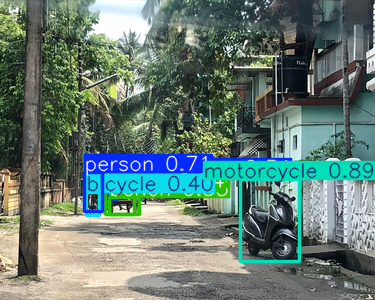

In [16]:
# Load the YOLOv5 model (assuming it's already loaded in the environment from a previous cell)
# If not, you would need to uncomment and run the model loading code:
# from ultralytics import YOLO
# model = YOLO('yolov5su.pt')

# For demonstration, let's use the same static image as before
image_path = '/content/bus.png' # Example image path

# --- Drone Control Placeholder Function ---
# Replace this with actual drone control commands for your drone
def send_drone_command(forward=0, right=0, up=0, yaw=0):
    print(f"Sending drone command: Forward={forward}, Right={right}, Up={up}, Yaw={yaw}")
    # Example for a Tello drone using djitellopy:
    # drone.send_rc_control(right, forward, up, yaw)
# ------------------------------------------


try:
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Could not load image from {image_path}")
    else:
        # Perform object detection
        # YOLO expects RGB images, but the YOLO model from ultralytics handles this
        results = model(frame)

        # Get detected objects and process them
        detections = []
        # The results object from ultralytics YOLO is a list of Results objects
        for r in results:
            boxes = r.boxes # Boxes object

            for box in boxes:
                # Extract detection information
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                confidence = box.conf[0].item()
                class_id = box.cls[0].item()
                class_name = model.names[int(class_id)]

                detections.append({
                    'xmin': x1,
                    'ymin': y1,
                    'xmax': x2,
                    'ymax': y2,
                    'confidence': confidence,
                    'name': class_name,
                    'center_x': (x1 + x2) / 2,
                    'center_y': (y1 + y2) / 2
                })


        # Simple Obstacle Avoidance Logic
        obstacle_detected = False
        for obj in detections:
            # Consider 'person' and 'car' as obstacles
            if obj['name'] in ['person', 'car'] and obj['confidence'] > 0.5:
                obstacle_detected = True
                # Simple logic: if an obstacle is detected, move backward
                print(f"Detected obstacle: {obj['name']} with confidence {obj['confidence']:.2f}")

                # Determine the obstacle's position in the frame
                x_center = obj['center_x']
                frame_center_x = frame.shape[1] / 2

                # Simple avoidance: move right if obstacle is on the left, left if on the right
                if x_center < frame_center_x:
                    send_drone_command(forward=0, right=20, up=0, yaw=0) # Move right
                else:
                    send_drone_command(forward=0, right=-20, up=0, yaw=0) # Move left

                # For this example, we'll just process the first significant obstacle and then stop
                break # Exit the loop after finding one obstacle


        if not obstacle_detected:
            print("No significant obstacles detected. Proceeding (conceptual).")
            # Example: if no obstacles, move forward
            # send_drone_command(forward=20, right=0, up=0, yaw=0)


        # Draw detected objects on frame for visualization
        # The results object from ultralytics YOLO has a plot() method
        annotated_frame = results[0].plot()


        # Display the annotated image in the notebook
        cv2_imshow(annotated_frame)

except Exception as e:
    print(f"An error occurred: {e}")

#main integration


In [18]:
import cv2
import time
from djitellopy import Tello

class SimpleDroneAI:
    def __init__(self):
        # Initialize components
        self.detector = SimpleObjectDetector()
        self.visual_odometry = SimpleVisualOdometry()

        # Initialize drone
        self.drone = Tello()
        self.drone.connect()
        self.drone.streamon()

        # Simple navigation state
        self.is_flying = False
        self.obstacle_threshold = 3  # Number of obstacles to trigger avoidance

    def simple_autonomous_flight(self):
        """Simple rule-based autonomous flight"""
        try:
            print("Taking off...")
            self.drone.takeoff()
            self.is_flying = True
            time.sleep(3)

            while self.is_flying:
                # Get frame
                frame = self.drone.get_frame_read().frame

                # Process frame
                obstacles = self.detector.detect_all(frame)
                position, rotation = self.visual_odometry.process_frame(frame)

                # Simple navigation logic
                self.navigate(obstacles, frame)

                # Display
                self.draw_detections(frame, obstacles)
                cv2.imshow("Drone View", frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

                time.sleep(0.1)

        finally:
            self.land()

    def navigate(self, obstacles, frame):
        """Simple obstacle avoidance navigation"""
        h, w = frame.shape[:2]
        center_x = w // 2

        # Check for obstacles in center area
        center_obstacles = []
        for obs in obstacles:
            if abs(obs['center'][0] - center_x) < w // 4:  # Center quarter
                center_obstacles.append(obs)

        if len(center_obstacles) >= self.obstacle_threshold:
            # Too many obstacles ahead, turn right
            print("Obstacles detected, turning right")
            self.drone.send_rc_control(0, 0, 0, 30)
        elif len(obstacles) > 0:
            # Some obstacles, move slowly
            print("Few obstacles, moving slowly")
            self.drone.send_rc_control(0, 10, 0, 0)
        else:
            # Clear path, move forward
            print("Clear path, moving forward")
            self.drone.send_rc_control(0, 20, 0, 0)

    def draw_detections(self, frame, obstacles):
        """Draw detected obstacles"""
        for obs in obstacles:
            x1, y1, x2, y2 = obs['bbox']
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, obs['type'], (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    def land(self):
        """Safe landing"""
        if self.is_flying:
            print("Landing...")
            self.drone.land()
            self.is_flying = False
        self.drone.streamoff()
        cv2.destroyAllWindows()

# Usage
if __name__ == "__main__":
    try:
        drone_ai = SimpleDroneAI()
        drone_ai.simple_autonomous_flight()
    except KeyboardInterrupt:
        print("Flight interrupted")
    except Exception as e:
        print(f"Error: {e}")


[INFO] tello.py - 129 - Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
INFO:djitellopy:Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds


Error: Command 'command' was unsuccessful for 4 tries. Latest response:	'Aborting command 'command'. Did not receive a response after 7 seconds'


#training the rl agent

In [19]:
def train_rl_agent():
    """Train RL agent in simulation first"""
    # Create environment
    detector = SimpleObjectDetector()
    visual_odometry = SimpleVisualOdometry()
    env = DroneEnv(detector, visual_odometry)

    # Train agent
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)

    # Save model
    model.save("simple_drone_policy")

    return model

# To use trained model:
# model = PPO.load("simple_drone_policy")
# action, _ = model.predict(observation)


#test

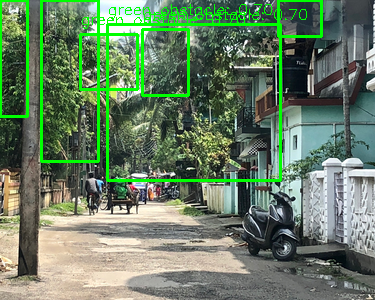

In [21]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import cv2_imshow for Colab

# Assuming SimpleObjectDetector class is defined in a previous cell

def test_detection():
    detector = SimpleObjectDetector()
    # Use a static image for testing in Colab
    image_path = '/content/bus.png' # Example image path

    frame = cv2.imread(image_path)

    if frame is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Test detection
    obstacles = detector.detect_all(frame)

    # Draw results
    for obs in obstacles:
        x1, y1, x2, y2 = obs['bbox']
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"{obs['type']}: {obs['confidence']:.2f}",
                   (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Display the annotated image in the notebook
    cv2_imshow(frame)

# Run the test function
test_detection()

In [31]:
import cv2
import numpy as np
# Assuming SimpleVisualOdometry class is defined in a previous cell
# from your_drone_system import SimpleVisualOdometry # Removed as class is in notebook

def run_visual_odometry_on_video(video_path):
    """Runs simple visual odometry on a video file and prints estimated position."""
    vo = SimpleVisualOdometry()
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    print("Processing video for visual odometry...")
    frame_count = 0

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            # Process frame
            position, rotation = vo.process_frame(frame)

            # Print estimated position periodically
            if frame_count % 10 == 0: # Print every 10 frames
                print(f"Frame {frame_count}: Estimated Position: x={position[0]:.2f}, y={position[1]:.2f}, z={position[2]:.2f}")

    except Exception as e:
        print(f"An error occurred during video processing: {e}")

    finally:
        cap.release()
        print("Finished video processing.")

# --- How to use ---
# 1. Upload a video file (e.g., my_drone_video.mp4) to your Colab environment.
# 2. Update the video_path below to the path of your uploaded video.
# 3. Run this cell.
video_path = '/content/Drone dataset for interactive driving scene.mp4' # <--- Update this path

# Run the visual odometry on the video
run_visual_odometry_on_video(video_path)

print("Visual odometry function defined. Please update 'video_path' and uncomment 'run_visual_odometry_on_video(video_path)' to run.")

Processing video for visual odometry...
Frame 10: Estimated Position: x=0.14, y=-0.07, z=0.12
Frame 20: Estimated Position: x=0.38, y=-0.28, z=0.34
Frame 30: Estimated Position: x=0.71, y=-0.60, z=0.71
Frame 40: Estimated Position: x=1.05, y=-0.82, z=1.06
Frame 50: Estimated Position: x=1.49, y=-1.17, z=1.43
Frame 60: Estimated Position: x=1.91, y=-1.22, z=1.77
Frame 70: Estimated Position: x=2.02, y=-1.33, z=1.88
Frame 80: Estimated Position: x=2.14, y=-1.45, z=2.00
Frame 90: Estimated Position: x=2.37, y=-1.68, z=2.23
Frame 100: Estimated Position: x=2.31, y=-1.73, z=2.32
Frame 110: Estimated Position: x=2.31, y=-1.73, z=2.32
Frame 120: Estimated Position: x=2.14, y=-1.37, z=2.71
Frame 130: Estimated Position: x=2.12, y=-1.48, z=2.32
Frame 140: Estimated Position: x=2.00, y=-1.47, z=1.69
Frame 150: Estimated Position: x=1.91, y=-1.31, z=1.78
Frame 160: Estimated Position: x=1.95, y=-1.42, z=1.64
Frame 170: Estimated Position: x=2.00, y=-1.46, z=1.55
Frame 180: Estimated Position: x=2

#test done connection

In [32]:
# test_drone_connection.py
from djitellopy import Tello
import time

def test_drone_connection():
    try:
        # Connect to drone
        drone = Tello()
        drone.connect()

        # Check battery and status
        battery = drone.get_battery()
        print(f"Battery: {battery}%")

        # Test camera stream
        drone.streamon()
        time.sleep(2)

        # Get a few frames
        for i in range(10):
            frame = drone.get_frame_read().frame
            print(f"Frame {i}: {frame.shape}")
            time.sleep(0.5)

        drone.streamoff()
        print("✅ Drone connection successful!")

    except Exception as e:
        print(f"❌ Drone connection failed: {e}")

if __name__ == "__main__":
    test_drone_connection()


[INFO] tello.py - 129 - Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
INFO:djitellopy:Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds


❌ Drone connection failed: Command 'command' was unsuccessful for 4 tries. Latest response:	'Aborting command 'command'. Did not receive a response after 7 seconds'


In [33]:
# test_basic_flight.py
from djitellopy import Tello
import time

def test_basic_flight():
    try:
        drone = Tello()
        drone.connect()

        battery = drone.get_battery()
        if battery < 20:
            print(f"❌ Battery too low: {battery}%")
            return

        print("✈️ Taking off...")
        drone.takeoff()
        time.sleep(3)

        print("📐 Moving in square pattern...")
        for i in range(4):
            drone.move_forward(50)
            time.sleep(2)
            drone.rotate_clockwise(90)
            time.sleep(2)

        print("🛬 Landing...")
        drone.land()

        print("✅ Basic flight test successful!")

    except Exception as e:
        print(f"❌ Flight test failed: {e}")

if __name__ == "__main__":
    test_basic_flight()


[INFO] tello.py - 129 - Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
INFO:djitellopy:Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds


❌ Flight test failed: Command 'command' was unsuccessful for 4 tries. Latest response:	'Aborting command 'command'. Did not receive a response after 7 seconds'


In [35]:
# safe_autonomous_test.py
import cv2
import time
# from your_drone_system import SimpleDroneAI # Removed incorrect import
from djitellopy import Tello # Import Tello class
from google.colab.patches import cv2_imshow # Import cv2_imshow for Colab

class SafeTestMode(): # Inheriting from SimpleDroneAI is not possible after removing import, define methods directly
    def __init__(self):
        # Initialize components - assuming SimpleObjectDetector and SimpleVisualOdometry are defined in previous cells
        self.detector = SimpleObjectDetector()
        self.visual_odometry = SimpleVisualOdometry()

        # Initialize drone - This part requires a physical drone and will not work in standard Colab
        self.drone = Tello()
        try:
            self.drone.connect()
            print("Tello drone connected.")
            self.drone.streamon()
            print("Tello video stream started.")
        except Exception as e:
            print(f"Could not connect to Tello drone or start stream: {e}")
            self.drone = None # Set drone to None if connection fails


        # Simple navigation state
        self.is_flying = False
        self.obstacle_threshold = 1  # Reduced threshold for conservative testing
        self.max_flight_time = 30  # Shorter max flight time for testing
        self.start_time = None
        self.safety_height = 50  # cm (lower safe height for testing)

    def safe_autonomous_flight(self):
        """Safe version for testing"""
        if self.drone is None:
            print("Cannot start flight without a drone connection.")
            return

        try:
            print("🔧 Starting safe test mode...")
            self.start_time = time.time()

            # Take off to safe height
            print("Taking off...")
            self.drone.takeoff()
            # self.drone.move_up(self.safety_height) # Optional: move to a specific height after takeoff
            self.is_flying = True
            time.sleep(5) # Give time for takeoff and stabilization

            while self.is_flying:
                # Safety timeout
                if time.time() - self.start_time > self.max_flight_time:
                    print("⏰ Safety timeout reached")
                    break

                # Get frame
                frame = self.drone.get_frame_read().frame
                if frame is None:
                    print("Could not get frame from drone stream.")
                    time.sleep(0.1)
                    continue

                # Process frame
                obstacles = self.detector.detect_all(frame)
                # Visual odometry processing requires consecutive frames and might not be reliable in this simple test setup
                # position, rotation = self.visual_odometry.process_frame(frame)


                # Safe navigation (slower movements)
                self.safe_navigate(obstacles, frame)

                # Display (using cv2_imshow for Colab)
                self.draw_info(frame, obstacles, (0,0,0)) # Pass dummy position for drawing
                cv2_imshow(frame)

                # No cv2.waitKey in Colab for interactive display, control loop with time.sleep or other means

                time.sleep(0.1)  # Slower loop for safety

        except Exception as e:
            print(f"Error during flight: {e}")

        finally:
            self.land()

    def safe_navigate(self, obstacles, frame):
        """Conservative navigation for testing"""
        h, w = frame.shape[:2]
        center_x = w // 2

        # More conservative obstacle detection
        center_obstacles = []
        for obs in obstacles:
            # Check if obstacle is in the lower half of the frame and in a wider central zone
            if obs['center'][1] > h // 2 and abs(obs['center'][0] - center_x) < w // 3:
                 # Consider only 'person' and 'colored_obstacle' types as critical obstacles for this simple test
                if obs['type'] in ['person', 'red_obstacle', 'green_obstacle', 'blue_obstacle']:
                    center_obstacles.append(obs)


        if len(center_obstacles) > 0:
            # Any detected critical obstacle in the lower central zone, stop and turn
            print("🛑 Critical obstacle detected, stopping and turning")
            # Send slower turning command
            self.drone.send_rc_control(0, 0, 0, 20)  # Slower turn
        else:
            # No critical obstacles in the lower central zone, move very slowly forward
            print("🐌 Moving slowly forward")
            # Send very slow forward command
            self.drone.send_rc_control(0, 10, 0, 0)  # Very slow forward

    def draw_info(self, frame, obstacles, position):
        """Draw comprehensive info on frame"""
        # Draw obstacles
        for obs in obstacles:
            x1, y1, x2, y2 = obs['bbox']
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, obs['type'], (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # Draw flight info
        flight_time = time.time() - self.start_time if self.start_time else 0
        cv2.putText(frame, f"Flight Time: {flight_time:.1f}s", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(frame, f"Obstacles: {len(obstacles)}", (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        # Display a dummy position since VO is not fully integrated
        cv2.putText(frame, f"Position: [N/A]", (10, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)


    def land(self):
        """Safe landing"""
        if self.drone is not None and self.is_flying:
            print("Landing...")
            self.drone.land()
            self.is_flying = False
        if self.drone is not None:
            self.drone.streamoff()
        # cv2.destroyAllWindows() # Not needed with cv2_imshow


# Run safe test (requires a connected Tello drone)
if __name__ == "__main__":
    try:
        safe_drone = SafeTestMode()
        safe_drone.safe_autonomous_flight()
    except KeyboardInterrupt:
        print("Flight interrupted by user")
    except Exception as e:
        print(f"An error occurred during safe flight test: {e}")

[INFO] tello.py - 129 - Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
INFO:djitellopy:Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds
[INFO] tello.py - 438 - Send command: 'command'
INFO:djitellopy:Send command: 'command'
[WARNING] tello.py - 448 - Aborting command 'command'. Did not receive a response after 7 seconds


Could not connect to Tello drone or start stream: Command 'command' was unsuccessful for 4 tries. Latest response:	'Aborting command 'command'. Did not receive a response after 7 seconds'
Cannot start flight without a drone connection.


In [36]:
# optimized_system.py
import cv2
import threading
from queue import Queue

class OptimizedDroneAI(SimpleDroneAI):
    def __init__(self):
        super().__init__()
        self.frame_queue = Queue(maxsize=2)
        self.processing_thread = None
        self.should_process = True

    def start_frame_processing(self):
        """Start background processing thread"""
        self.processing_thread = threading.Thread(target=self.process_frames)
        self.processing_thread.daemon = True
        self.processing_thread.start()

    def process_frames(self):
        """Background frame processing"""
        while self.should_process:
            if not self.frame_queue.empty():
                frame = self.frame_queue.get()

                # Process in background
                obstacles = self.detector.detect_all(frame)
                position, rotation = self.visual_odometry.process_frame(frame)


                self.navigate(obstacles, frame)

    def optimized_flight(self):
        """Optimized flight loop"""
        try:
            self.start_frame_processing()
            self.drone.takeoff()
            self.is_flying = True

            while self.is_flying:

                frame = self.drone.get_frame_read().frame


                if not self.frame_queue.full():
                    self.frame_queue.put(frame)


                cv2.imshow("Optimized Flight", frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        finally:
            self.should_process = False
            self.land()


In [37]:
def pre_flight_checklist(drone):
    """Comprehensive pre-flight safety check"""
    checks = []


    battery = drone.get_battery()
    checks.append(("Battery", battery >= 30, f"{battery}%"))


    try:
        drone.streamon()
        frame = drone.get_frame_read().frame
        drone.streamoff()
        checks.append(("Camera", frame is not None, "Working"))
    except:
        checks.append(("Camera", False, "Failed"))


    print("🔍 Pre-Flight Checklist:")
    for check_name, passed, detail in checks:
        status = "✅" if passed else "❌"
        print(f"{status} {check_name}: {detail}")

    return all(check[1] for check in checks)


In [38]:
class EmergencyHandler:
    def __init__(self, drone):
        self.drone = drone
        self.emergency_landing = False

    def monitor_emergency_conditions(self):
        """Monitor for emergency conditions"""
        battery = self.drone.get_battery()

        if battery < 15:
            print("🚨 EMERGENCY: Low battery!")
            self.emergency_land()



    def emergency_land(self):
        """Emergency landing procedure"""
        if not self.emergency_landing:
            self.emergency_landing = True
            print("🚨 EMERGENCY LANDING INITIATED")
            self.drone.emergency()


In [39]:
import cv2
import numpy as np
import time
# Assuming SimpleObjectDetector and SimpleVisualOdometry classes are defined in previous cells
# Assuming model (YOLO) is loaded in a previous cell
# Assuming cv2_imshow is imported from google.colab.patches

# --- Drone Control Placeholder Function ---
# Replace this with actual drone control commands for your drone
def send_drone_command(forward=0, right=0, up=0, yaw=0):
    print(f"Sending drone command: Forward={forward}, Right={right}, Up={up}, Yaw={yaw}")
    # Example for a Tello drone using djitellopy:
    # drone.send_rc_control(right, forward, up, yaw)
# ------------------------------------------

# --- Simplified Navigation Logic ---
def simple_integrated_navigation(detector, visual_odometry, yolo_model, frame):
    """Combines object detection and visual odometry for simple navigation decisions."""

    # 1. Perform Object Detection
    # YOLO expects RGB images, but the YOLO model from ultralytics handles this
    yolo_results = yolo_model(frame)
    detections = []
    for r in yolo_results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = box.conf[0].item()
            class_id = box.cls[0].item()
            class_name = yolo_model.names[int(class_id)]
            detections.append({
                'xmin': x1, 'ymin': y1, 'xmax': x2, 'ymax': y2,
                'confidence': confidence, 'name': class_name,
                'center_x': (x1 + x2) / 2, 'center_y': (y1 + y2) / 2
            })

    # You could also use the SimpleObjectDetector if preferred
    # simple_detector_obstacles = detector.detect_all(frame)
    # Combine or choose which detections to prioritize

    # 2. Process Visual Odometry (requires previous frame)
    # In a real loop, you would feed consecutive frames
    # For this static example, VO won't show motion, but the structure is here
    current_position, current_rotation = visual_odometry.process_frame(frame)

    # 3. Make Navigation Decision based on Detections and Pose
    command = {'forward': 0, 'right': 0, 'up': 0, 'yaw': 0}
    obstacle_ahead = False
    frame_center_x = frame.shape[1] / 2
    frame_lower_half_y = frame.shape[0] / 2

    for obj in detections:
        # Consider obstacles in the lower half of the frame and near the center
        if obj['name'] in ['person', 'car'] and obj['confidence'] > 0.5 and \
           obj['center_y'] > frame_lower_half_y and abs(obj['center_x'] - frame_center_x) < frame.shape[1] / 4:
            obstacle_ahead = True
            print(f"Obstacle '{obj['name']}' detected ahead.")

            # Simple avoidance strategy: turn away from the obstacle
            if obj['center_x'] < frame_center_x:
                # Obstacle on the left, turn right
                command['yaw'] = 20
            else:
                # Obstacle on the right, turn left
                command['yaw'] = -20

            # Stop forward movement when avoiding
            command['forward'] = 0

            # For simplicity, handle the first significant obstacle and stop
            break

    if not obstacle_ahead:
        # No significant obstacles ahead, move forward (conceptually)
        print("Path seems clear. Moving forward.")
        command['forward'] = 10 # Small forward movement

        # You could also add logic here to move towards a target using visual odometry
        # For example:
        # target_position = np.array([X, Y, Z])
        # direction_vector = target_position - current_position
        # if np.linalg.norm(direction_vector) > some_threshold:
        #     # Adjust forward/yaw based on direction_vector
        #     pass


    # Send the determined command (conceptual)
    send_drone_command(command['forward'], command['right'], command['up'], command['yaw'])

    # Return the annotated frame for visualization
    annotated_frame = yolo_results[0].plot()
    return annotated_frame

# --- Example Usage (requires a frame, detector, visual_odometry, and yolo_model) ---
# To run this, you would need a loop that continuously gets frames,
# initializes detector and visual_odometry outside the loop,
# and calls simple_integrated_navigation with each frame.

# Example with a static image (for demonstration in Colab)
# image_path = '/content/bus.png' # Make sure this image exists and is updated
# frame_for_test = cv2.imread(image_path)

# if frame_for_test is not None:
    # Initialize detector and visual_odometry once
#    simple_detector_instance = SimpleObjectDetector()
#    simple_vo_instance = SimpleVisualOdometry()
    # Assuming YOLO model is already loaded as 'model'

    # Run the navigation logic on the static frame
#    annotated_output_frame = simple_integrated_navigation(
#        simple_detector_instance, simple_vo_instance, model, frame_for_test
#    )

    # Display the result
#    cv2_imshow(annotated_output_frame)
# else:
#    print(f"Error: Could not load frame from {image_path} for navigation test.")

print("simple_integrated_navigation function defined. Uncomment the example usage section and provide a valid frame and model to run.")

simple_integrated_navigation function defined. Uncomment the example usage section and provide a valid frame and model to run.



0: 512x640 3 persons, 1 bicycle, 1 motorcycle, 2 benchs, 510.7ms
Speed: 4.3ms preprocess, 510.7ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)
Path seems clear. Moving forward.
Sending drone command: Forward=10, Right=0, Up=0, Yaw=0


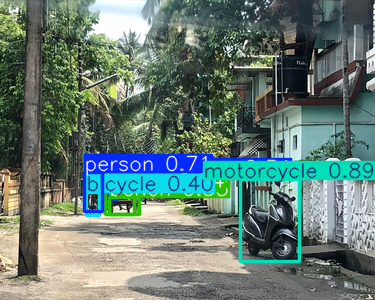

In [40]:
# Example Usage (for demonstration with a static image in Colab)

# Assuming 'model' (YOLO) is loaded, SimpleObjectDetector and SimpleVisualOdometry classes are defined

image_path = '/content/bus.png' # Make sure this image exists and is updated
frame_for_test = cv2.imread(image_path)

if frame_for_test is not None:
    # Initialize detector and visual_odometry once
    simple_detector_instance = SimpleObjectDetector()
    simple_vo_instance = SimpleVisualOdometry()
    # Assuming YOLO model is already loaded as 'model'

    # Run the navigation logic on the static frame
    annotated_output_frame = simple_integrated_navigation(
        simple_detector_instance, simple_vo_instance, model, frame_for_test
    )

    # Display the result
    cv2_imshow(annotated_output_frame)
else:
    print(f"Error: Could not load frame from {image_path} for navigation test.")

In [43]:
def train_rl_agent():
    """Train RL agent in simulation first"""
    # Create environment
    detector = SimpleObjectDetector()
    visual_odometry = SimpleVisualOdometry()
    env = DroneEnv(detector, visual_odometry)

    # Train agent
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)

    # Save model
    model.save("simple_drone_policy")

    return model

# To use trained model:
# model = PPO.load("simple_drone_policy")
# action, _ = model.predict(observation)

train_rl_agent() # Execute the training function

Using cpu device


ImportError: Missing shimmy installation. You provided an OpenAI Gym environment. Stable-Baselines3 (SB3) has transitioned to using Gymnasium internally. In order to use OpenAI Gym environments with SB3, you need to install shimmy (`pip install 'shimmy>=2.0'`).

In [44]:
!pip install 'shimmy>=0.2.1'

In [45]:
def train_rl_agent():
    """Train RL agent in simulation first"""
    # Create environment
    detector = SimpleObjectDetector()
    visual_odometry = SimpleVisualOdometry()
    env = DroneEnv(detector, visual_odometry)

    # Train agent
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)

    # Save model
    model.save("simple_drone_policy")

    return model

# To use trained model:
# model = PPO.load("simple_drone_policy")
# action, _ = model.predict(observation)

train_rl_agent() # Execute the training function

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode timeout.
Episode timeout.
Episode timeout.
Episode timeout.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -439     |
| time/              |          |
|    fps             | 1288     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
Episode timeout.
Episode timeout.
Episode timeout.
Episode timeout.
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 500         |
|    ep_rew_mean          | -379        |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    appro

In [46]:
import gym
import numpy as np
from stable_baselines3 import PPO

# Assuming DroneEnv, SimpleObjectDetector, SimpleVisualOdometry classes are defined
# Assuming the model was saved as "simple_drone_policy" in the previous step

def test_trained_agent(model_path="simple_drone_policy"):
    """Load and test the trained RL agent."""
    try:
        # Load the trained model
        model = PPO.load(model_path)
        print(f"Trained model loaded from {model_path}")

        # Create the environment (needs to be the same as the training environment)
        detector = SimpleObjectDetector()
        visual_odometry = SimpleVisualOdometry()
        env = DroneEnv(detector, visual_odometry)

        print("Testing the trained agent...")
        num_episodes = 5 # Run for a few episodes to see performance

        for episode in range(num_episodes):
            obs = env.reset()
            done = False
            episode_reward = 0
            print(f"\n--- Episode {episode + 1} ---")

            # In a real scenario, you would get frames here and update env.current_frame
            # For this conceptual test, we'll just run the environment loop

            while not done:
                # Get action from the trained agent
                action, _states = model.predict(obs, deterministic=True) # Use deterministic=True for consistent testing

                # Take a step in the environment (conceptually)
                # Note: The observation returned by env.step() here will be based on the simplified
                # environment simulation and potential dummy frame in _get_observation().
                # For a realistic test, you would need to feed real or simulated frames
                # into env.step() and update env.current_frame accordingly before calling _get_observation().
                obs, reward, done, info = env.step(action)

                episode_reward += reward
                # print(f"Step: {env.time_step}, Action: {action}, Reward: {reward:.2f}, Done: {done}")

            print(f"Episode {episode + 1} finished with total reward: {episode_reward:.2f}")

    except Exception as e:
        print(f"An error occurred during testing: {e}")
        print("Please ensure the model file 'simple_drone_policy.zip' exists.")

# Run the test function
test_trained_agent()

Trained model loaded from simple_drone_policy
Testing the trained agent...

--- Episode 1 ---
Target reached!
Episode 1 finished with total reward: 63.75

--- Episode 2 ---
Target reached!
Episode 2 finished with total reward: 63.75

--- Episode 3 ---
Target reached!
Episode 3 finished with total reward: 63.75

--- Episode 4 ---
Target reached!
Episode 4 finished with total reward: 63.75

--- Episode 5 ---
Target reached!
Episode 5 finished with total reward: 63.75


In [47]:
from google.colab import files

# Assuming the model was saved as "simple_drone_policy.zip"
try:
  files.download('simple_drone_policy.zip')
  print("Downloaded 'simple_drone_policy.zip'")
except FileNotFoundError:
  print("Error: 'simple_drone_policy.zip' not found. Please ensure the model was saved successfully.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded 'simple_drone_policy.zip'
